In [1310]:
#https://www.alphavantage.co/academy/#ai-for-finance

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

import requests
import pandas as pd
from pandas.io.json import json_normalize

print("All libraries loaded")

All libraries loaded


In [1311]:
#Get Basic Stock Data

# Replace "demo" with your own API key from https://www.alphavantage.co/support/#api-key
apikey = "NA4DC7S59VGKCP4Y"
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&apikey={apikey}&outputsize=full'

# Send a GET request to the API
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data['Time Series (Daily)']

# Create a DataFrame from the time series data
df = pd.DataFrame(time_series).T

# Rename the columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient']

# Convert the column data types
df = df.astype({
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Adjusted Close': float,
    'Volume': int,
    'Dividend Amount': float,
    'Split Coefficient': float
})

# Sort the DataFrame by date
df.sort_index(ascending=True, inplace=True)

# Reset the index
df.reset_index(inplace=True)

df.rename(columns={'index': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Specify the desired start and end dates
start_date = '2010-06-01'
end_date = '2023-06-30'

# Filter the DataFrame based on the start and end dates
filtered_basic = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Reset the index without keeping the original index values
filtered_basic.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_basic.head)



<bound method NDFrame.head of            Date    Open    High      Low    Close  Adjusted Close    Volume  \
0    2010-06-01  259.69  265.94  258.960  260.830        7.916523  31302600   
1    2010-06-02  264.54  264.80  260.335  263.950        8.011219  24591000   
2    2010-06-03  265.18  265.55  260.410  263.120        7.986027  23218100   
3    2010-06-04  258.21  261.90  254.630  255.965        7.768864  27082300   
4    2010-06-07  258.29  259.15  250.550  250.940        7.616349  31676500   
...         ...     ...     ...      ...      ...             ...       ...   
3289 2023-06-26  186.83  188.05  185.230  185.270      185.270000  48088661   
3290 2023-06-27  185.89  188.39  185.670  188.060      188.060000  50730846   
3291 2023-06-28  187.93  189.90  187.600  189.250      189.250000  51216801   
3292 2023-06-29  189.08  190.07  188.940  189.590      189.590000  46347308   
3293 2023-06-30  191.63  194.48  191.260  193.970      193.970000  85213216   

      Dividend Amount

In [1312]:
config = {
    "alpha_vantage": {
        "key": 'NA4DC7S59VGKCP4Y', # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },

    "alpha_vantage": {
        "symbol": "AAPL",  # Replace with your desired symbol
        "outputsize": "full",  # Replace with your desired output size
        "key_adjusted_close": "5. adjusted close"  # Replace with the appropriate key for adjusted close price
    },
    "plots": {
        "color_actual": "blue",  # Replace with your desired color
        "xticks_interval": 10,  # Replace with your desired interval for x-ticks
        "color_train": "#3D9970",  # Define the color for the training data
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    
    }

    
}

In [1313]:
#Get inflation data

# Replace the "demo" API key below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INFLATION&apikey=NA4DC7S59VGKCP4Y'
r = requests.get(url)
data = r.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Normalize the "data" column
inflation = json_normalize(df['data'])

# Add the normalized data as columns to the DataFrame
df['date'] = inflation['date']
df['value'] = inflation['value']

# Rename the 'DATE' column to 'Date'
inflation.rename(columns={'date': 'Date'}, inplace=True)

# Filter the data based on the desired date range
start_date = '2010-06-01'
end_date = '2023-06-30'
filtered_inflation = inflation[(inflation['Date'] >= start_date) & (inflation['Date'] <= end_date)]



/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_2904/2785394002.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  inflation = json_normalize(df['data'])


In [1314]:
#merge data

# Convert the 'Date' column in filtered_inflation to datetime
filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])

import pandas as pd

# Merge the inflation dataset using concat
merged_data = pd.concat([filtered_basic.set_index('Date'), filtered_inflation.set_index('Date')['value']], axis=1, join='outer')

# Fill missing values for all columns
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

# Check missing values
missing_values = merged_data.isnull().sum()
print(missing_values)

# Convert "value" column to float
merged_data['value'] = merged_data['value'].astype(float)

# Display the merged DataFrame
print(merged_data)


Open                 0
High                 0
Low                  0
Close                0
Adjusted Close       0
Volume               0
Dividend Amount      0
Split Coefficient    0
value                0
dtype: int64
              Open    High      Low    Close  Adjusted Close      Volume  \
Date                                                                       
2010-06-01  259.69  265.94  258.960  260.830        7.916523  31302600.0   
2010-06-02  264.54  264.80  260.335  263.950        8.011219  24591000.0   
2010-06-03  265.18  265.55  260.410  263.120        7.986027  23218100.0   
2010-06-04  258.21  261.90  254.630  255.965        7.768864  27082300.0   
2010-06-07  258.29  259.15  250.550  250.940        7.616349  31676500.0   
...            ...     ...      ...      ...             ...         ...   
2023-06-26  186.83  188.05  185.230  185.270      185.270000  48088661.0   
2023-06-27  185.89  188.39  185.670  188.060      188.060000  50730846.0   
2023-06-28  187.93  

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_2904/832202225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])


In [1315]:


from sklearn.model_selection import train_test_split


x = merged_data[['Open', 'High','Low', 'Volume', 'Split Coefficient', 'value']]
y = merged_data['Close']

# Linear regression Model for stock prediction 
train_xGraph, test_xGraph, train_yGraph, test_yGraph = train_test_split(merged_data.index, y, test_size=0.15 , shuffle=False,random_state = 0)




In [1316]:
# let's check if total observation makes sense
print(train_xGraph.shape )
print(test_xGraph.shape)
print(train_yGraph.shape)
print(test_yGraph.shape)

(2810,)
(496,)
(2810,)
(496,)


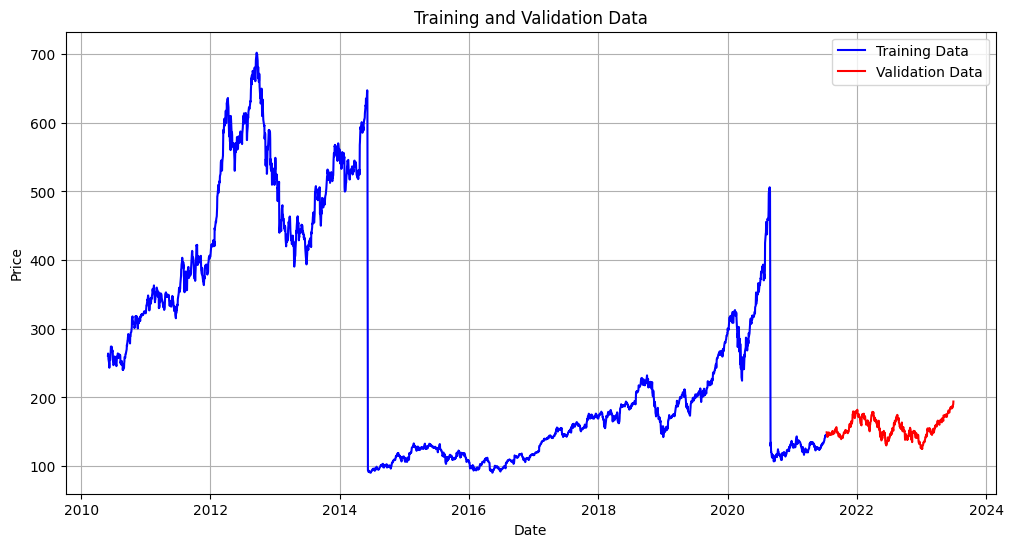

In [1317]:

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_xGraph, train_yGraph, label="Training Data", color="blue")
plt.plot(test_xGraph, test_yGraph, label="Validation Data", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Training and Validation Data")
plt.legend()
plt.grid(True)
plt.show()

In [1318]:
#Perform regression analysis



#Setup for regression analysis

x = merged_data[['Open', 'High','Low', 'Volume', 'Split Coefficient', 'value']]
y = merged_data['Close']


# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)

# let's check if total observation makes sense
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)



(2810, 6)
(496, 6)
(2810,)
(496,)


In [1319]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
regression = LinearRegression()
regression.fit(train_x, train_y)

print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

# the coefficient of determination R²/ Cofidence of regression
regression_confidence = regression.score(train_x, train_y)
print("linear regression confidence: ", regression_confidence)


#Calculate predicted price
predicted=regression.predict(test_x)

dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})
dfr.tail(10)


#Acurracy of model
x2 = dfr.Actual_Price.mean()
y2 = dfr.Predicted_Price.mean()
Accuracy1 = x2/y2*100
print("The accuracy of the model is " , Accuracy1)


regression coefficient [-6.53620790e-01  8.78672305e-01  7.74474581e-01 -1.43426948e-09
  1.16010470e-01  4.71759912e-02]
regression intercept -0.17925950502774413
linear regression confidence:  0.9998789364704483
The accuracy of the model is  99.83917468194295


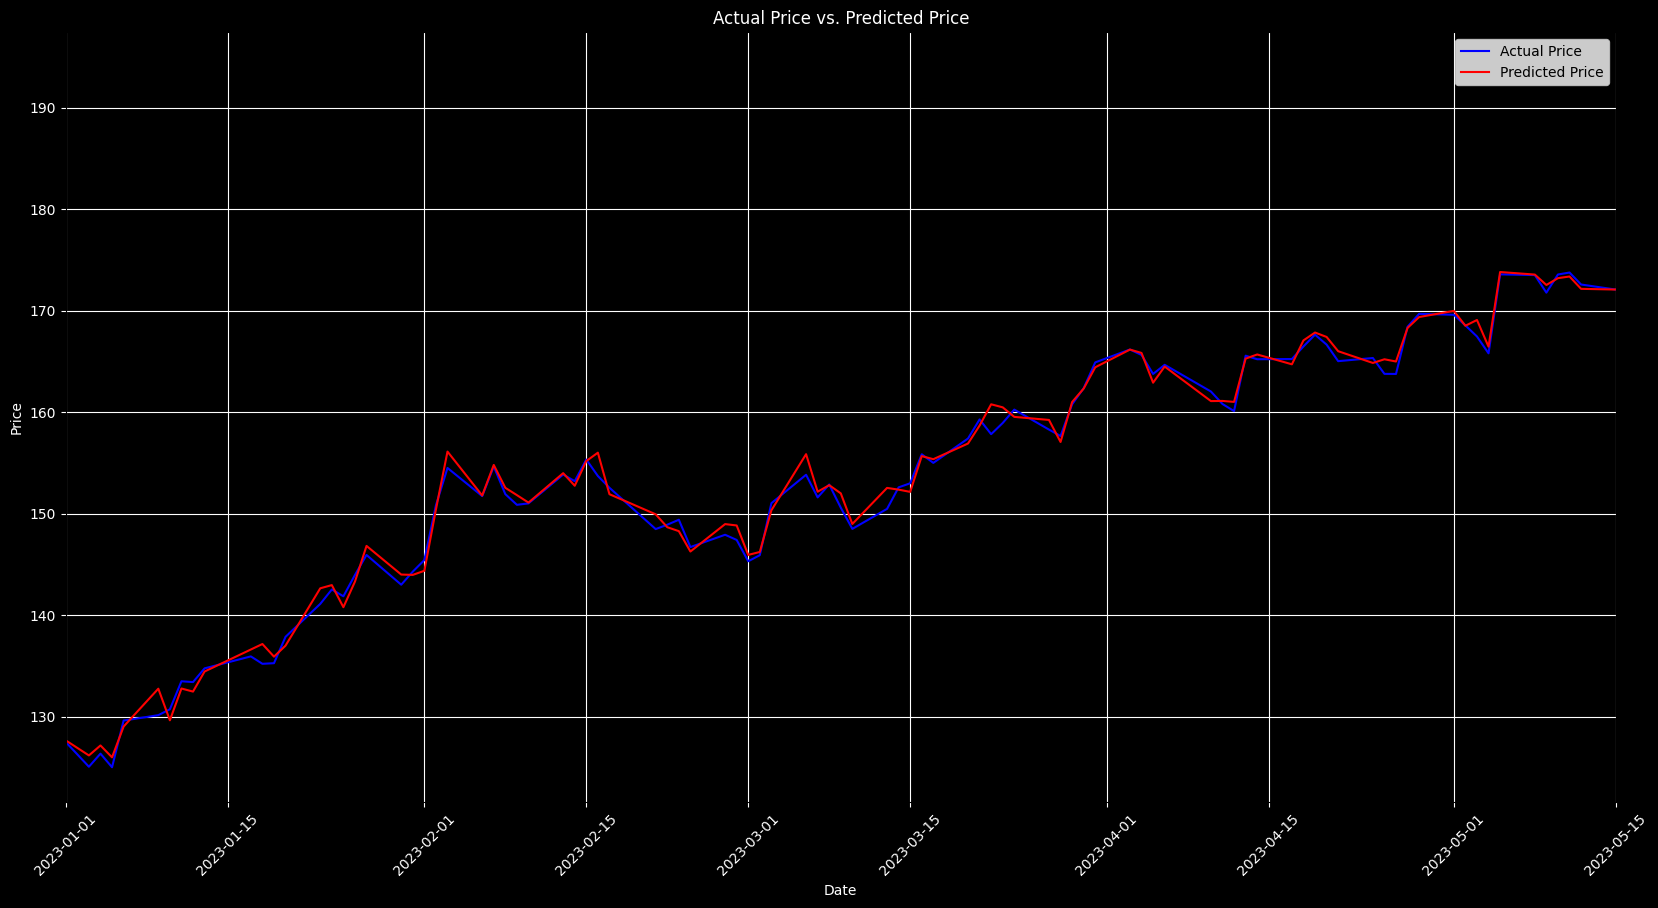

In [1320]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Plotting the actual price and predicted price
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('black')
ax.plot(dfr.index, dfr['Actual_Price'], label='Actual Price', color="blue")
ax.plot(dfr.index, dfr['Predicted_Price'], label='Predicted Price', color="red")
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Price', color='white')
ax.set_title('Actual Price vs. Predicted Price', color='white')
ax.legend()
ax.grid(color='white')
ax.tick_params(colors='white')

# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-05-15'
start_datetime = pd.to_datetime(start_date)
end_datetime = pd.to_datetime(end_date)
ax.set_xlim(start_datetime, end_datetime)

# Format the date ticks
date_formatter = DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)

plt.show()


In [1321]:
merged_data

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient,value
Date,,,,,,,,,
2010-06-01,259.69,265.94,258.960,260.830,7.916523,31302600.0,0.0,1.0,3.156842
2010-06-02,264.54,264.80,260.335,263.950,8.011219,24591000.0,0.0,1.0,3.156842
2010-06-03,265.18,265.55,260.410,263.120,7.986027,23218100.0,0.0,1.0,3.156842
2010-06-04,258.21,261.90,254.630,255.965,7.768864,27082300.0,0.0,1.0,3.156842
2010-06-07,258.29,259.15,250.550,250.940,7.616349,31676500.0,0.0,1.0,3.156842
...,...,...,...,...,...,...,...,...,...
2023-06-26,186.83,188.05,185.230,185.270,185.270000,48088661.0,0.0,1.0,8.002800
2023-06-27,185.89,188.39,185.670,188.060,188.060000,50730846.0,0.0,1.0,8.002800
2023-06-28,187.93,189.90,187.600,189.250,189.250000,51216801.0,0.0,1.0,8.002800


In [1322]:
import pandas as pd
import sklearn.preprocessing

# Assuming you have already defined `merged_data_normalized` and `scaler` as in your code
from sklearn.preprocessing import MinMaxScaler

# Drop the "Adjusted Close" and "Volume" columns
merged_data.drop(["Adjusted Close", "Volume", "Dividend Amount", "Split Coefficient", "value"], axis=1, inplace=True)

scaler = MinMaxScaler()
merged_data_normalized = scaler.fit_transform(merged_data)
merged_data_unnormalized = scaler.inverse_transform(merged_data_normalized)

# Convert merged_data_normalized to a Pandas DataFrame
columns = merged_data.columns  # Assuming 'merged_data' is a DataFrame
merged_data_normalized_df = pd.DataFrame(merged_data_normalized, columns=columns)


# Display the resulting DataFrame
print(merged_data_normalized_df)


          Open      High       Low     Close
0     0.277086  0.285235  0.277807  0.278758
1     0.285005  0.283380  0.280061  0.283858
2     0.286050  0.284600  0.280184  0.282501
3     0.274669  0.278659  0.270710  0.270807
4     0.274800  0.274183  0.264022  0.262594
...        ...       ...       ...       ...
3301  0.158113  0.158455  0.156958  0.155258
3302  0.156578  0.159008  0.157679  0.159818
3303  0.159909  0.161466  0.160842  0.161763
3304  0.161787  0.161743  0.163039  0.162319
3305  0.165951  0.168921  0.166842  0.169478

[3306 rows x 4 columns]


In [1323]:
import numpy as np
seq_len=20
sequences=[]
for index in range(len(merged_data_normalized_df) - seq_len): 
  sequences.append(merged_data_normalized_df[index: index + seq_len])
sequences= np.array(sequences)

In [1324]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))  
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]
    
x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]
    
x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [1325]:
import torch
from torch.utils.data import TensorDataset, DataLoader

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [1326]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(4,64,batch_first=True) ##select amount (#, 64)
        self.fc    = nn.Linear(64,4)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork()

#push to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = model.to(device)

In [1327]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()


In [1328]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [1329]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [1330]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\tVal Loss: {valid_loss:.5f}\n')

Epoch  1
	Train Loss: 1.67533
	Val Loss: 0.00008

Epoch  2
	Train Loss: 0.15027
	Val Loss: 0.00004

Epoch  3
	Train Loss: 0.12507
	Val Loss: 0.00004

Epoch  4
	Train Loss: 0.10535
	Val Loss: 0.00003

Epoch  5
	Train Loss: 0.09737
	Val Loss: 0.00003

Epoch  6
	Train Loss: 0.08474
	Val Loss: 0.00005

Epoch  7
	Train Loss: 0.07587
	Val Loss: 0.00003

Epoch  8
	Train Loss: 0.08386
	Val Loss: 0.00016

Epoch  9
	Train Loss: 0.07113
	Val Loss: 0.00004

Epoch  10
	Train Loss: 0.06786
	Val Loss: 0.00004

Epoch  11
	Train Loss: 0.06718
	Val Loss: 0.00006

Epoch  12
	Train Loss: 0.06857
	Val Loss: 0.00007

Epoch  13
	Train Loss: 0.06313
	Val Loss: 0.00006

Epoch  14
	Train Loss: 0.05828
	Val Loss: 0.00003

Epoch  15
	Train Loss: 0.05879
	Val Loss: 0.00002

Epoch  16
	Train Loss: 0.05586
	Val Loss: 0.00003

Epoch  17
	Train Loss: 0.05620
	Val Loss: 0.00010

Epoch  18
	Train Loss: 0.05556
	Val Loss: 0.00005

Epoch  19
	Train Loss: 0.05486
	Val Loss: 0.00011

Epoch  20
	Train Loss: 0.05128
	Val Loss

In [1331]:
model=torch.load('saved_weights.pt')

x_test= torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

In [1332]:
predictUn = scaler.inverse_transform(y_test_pred)

ActualUn = scaler.inverse_transform(y_test)

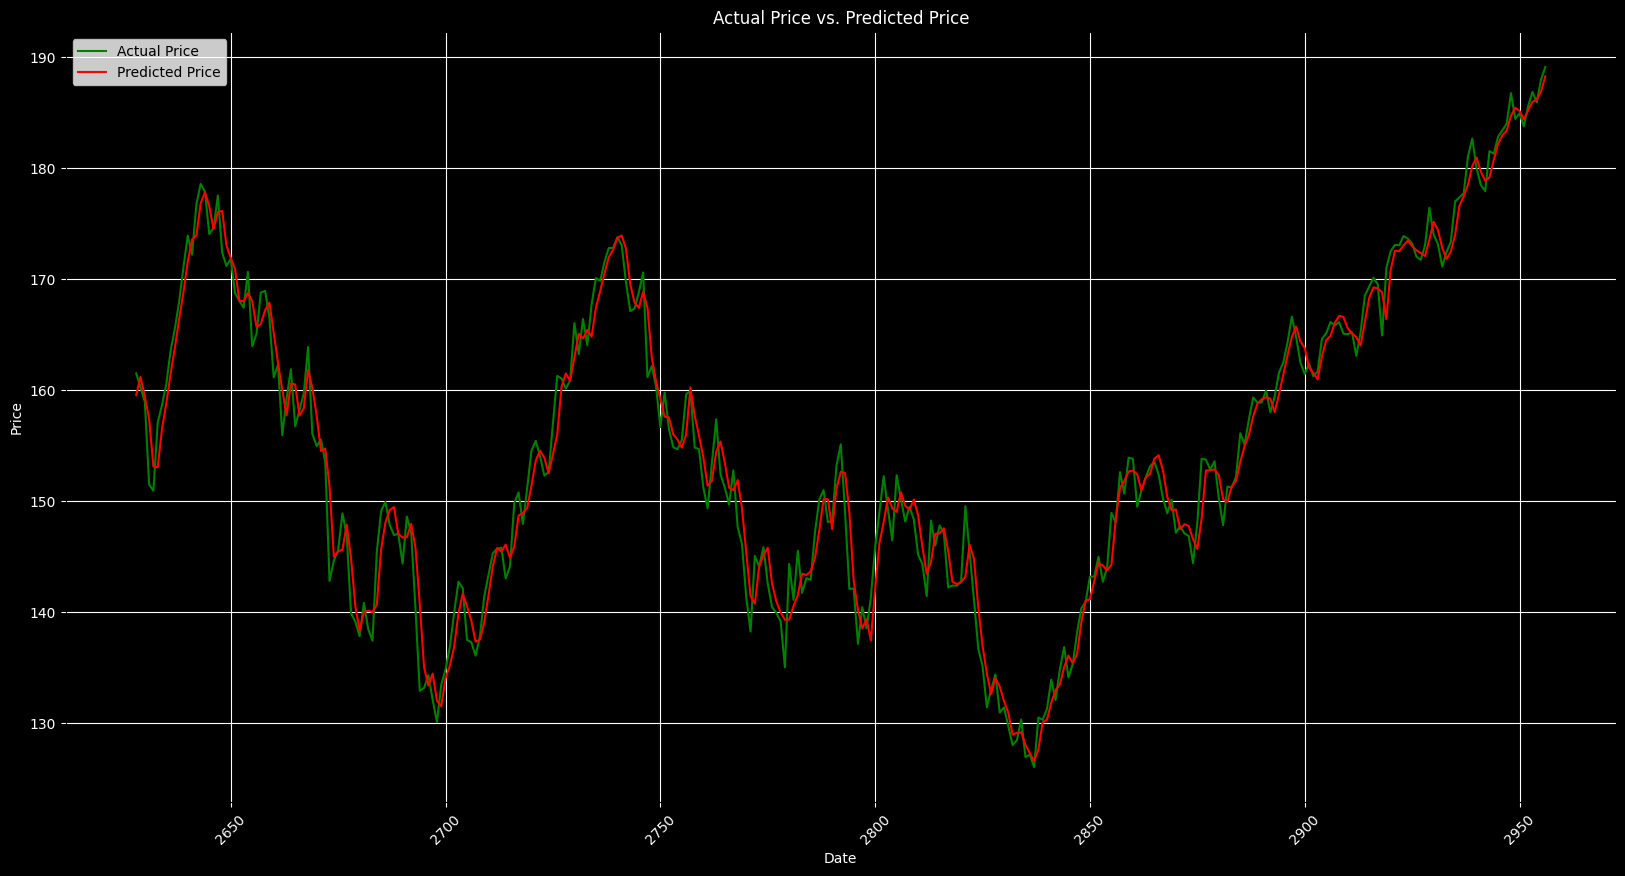

In [1333]:


# Plotting the actual price and predicted price
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('black')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         ActualUn[:,0], color='green', label='Actual Price')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         predictUn[:,0], color='red', label='Predicted Price')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Price', color='white')
ax.set_title('Actual Price vs. Predicted Price', color='white')
ax.legend()
ax.grid(color='white')
ax.tick_params(colors='white')


plt.xticks(rotation=45)

plt.show()

In [1334]:
# Assuming idx is defined earlier
actual_prices = y_test[:, 0]
predicted_prices = y_test_pred[:, 0]  # No need to call .numpy() here

# Calculate the Mean Squared Error (MSE)
mse = np.mean((actual_prices - predicted_prices) ** 2)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the accuracy
accuracy = 100 * (1 - rmse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Accuracy:", accuracy, "%")


Mean Squared Error (MSE): 1.3138430025999263e-05
Root Mean Squared Error (RMSE): 0.0036246972323215167
Accuracy: 99.63753027676785 %


In [1335]:
# Assuming idx is defined earlier
predicted_prices_df = pd.DataFrame(y_test_pred)


predictUn = scaler.inverse_transform(predicted_prices_df)

predictUn


# Assuming idx is defined earlier
predictUn_df= pd.DataFrame(predictUn)

# Assuming you have a list of original column names, for example:
original_column_names = ['Open predicted', 'High predicted', 'Low predicted', 'Close predicted']

# Rename the columns of the DataFrame with the original column names
predictUn_df.columns = original_column_names

predictUn_df


,Open predicted,High predicted,Low predicted,Close predicted
0,159.522827,161.030533,157.351456,159.162994
1,161.164139,162.577072,158.904602,160.806900
2,159.392487,160.765564,157.190842,158.974976
3,157.380096,158.771866,155.216782,156.999283
4,153.082153,154.454285,150.896439,152.617218
...,...,...,...,...
324,185.182159,186.761810,182.691391,184.704849
325,185.928604,187.519562,183.464996,185.459152
326,186.147461,187.771576,183.736526,185.714172
327,186.855560,188.458206,184.405685,186.387177


In [1336]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Define a new NeuralNetwork class with GRU
class GRUNeuralNetwork(nn.Module):
    def __init__(self):
        super(GRUNeuralNetwork, self).__init__()
        self.gru = nn.GRU(input_size=4, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        output, hidden = self.gru(x)
        x = self.fc(output[:, -1, :])  # Take the last hidden state and pass it to the linear layer
        return x

# Assuming you have defined the training and validation DataLoader objects
n_epochs = 50
best_valid_loss = float('inf')

model = GRUNeuralNetwork()

# Push the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




In [1337]:
# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in valid_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            valid_loss += loss.item()

    valid_loss /= len(valid_dataloader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru_model.pt')

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}")

# After training, load the best model and make predictions
model.load_state_dict(torch.load('gru_model.pt'))
model.eval()

x_test = torch.tensor(x_test).float().to(device)
with torch.no_grad():
    y_test_pred = model(x_test)






Epoch 1: Train Loss: 0.01786, Valid Loss: 0.00005
Epoch 2: Train Loss: 0.00112, Valid Loss: 0.00005
Epoch 3: Train Loss: 0.00103, Valid Loss: 0.00004
Epoch 4: Train Loss: 0.00083, Valid Loss: 0.00003
Epoch 5: Train Loss: 0.00075, Valid Loss: 0.00002
Epoch 6: Train Loss: 0.00071, Valid Loss: 0.00004
Epoch 7: Train Loss: 0.00071, Valid Loss: 0.00003
Epoch 8: Train Loss: 0.00070, Valid Loss: 0.00007
Epoch 9: Train Loss: 0.00072, Valid Loss: 0.00002
Epoch 10: Train Loss: 0.00062, Valid Loss: 0.00002
Epoch 11: Train Loss: 0.00063, Valid Loss: 0.00020
Epoch 12: Train Loss: 0.00075, Valid Loss: 0.00002
Epoch 13: Train Loss: 0.00060, Valid Loss: 0.00013
Epoch 14: Train Loss: 0.00064, Valid Loss: 0.00002
Epoch 15: Train Loss: 0.00062, Valid Loss: 0.00003
Epoch 16: Train Loss: 0.00060, Valid Loss: 0.00009
Epoch 17: Train Loss: 0.00069, Valid Loss: 0.00002
Epoch 18: Train Loss: 0.00059, Valid Loss: 0.00002
Epoch 19: Train Loss: 0.00062, Valid Loss: 0.00002
Epoch 20: Train Loss: 0.00059, Valid Los

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_2904/3738387561.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test).float().to(device)


In [1338]:
# Assuming idx is defined earlier
predicted_prices_df = pd.DataFrame(y_test_pred)


predictUn = scaler.inverse_transform(predicted_prices_df)

predictUn


# Assuming idx is defined earlier
predictUn_df= pd.DataFrame(predictUn)

# Assuming you have a list of original column names, for example:
original_column_names = ['Open predicted', 'High predicted', 'Low predicted', 'Close predicted']

# Rename the columns of the DataFrame with the original column names
predictUn_df.columns = original_column_names

predictUn_df

,Open predicted,High predicted,Low predicted,Close predicted
0,160.138626,161.573380,157.959641,159.656128
1,161.415344,162.926453,159.351257,160.904663
2,159.736710,161.222610,157.646759,159.235260
3,157.787689,159.207855,155.675827,157.326950
4,153.914047,155.192932,151.766083,153.435547
...,...,...,...,...
324,185.159500,186.855011,182.748978,184.381851
325,185.863770,187.578110,183.440887,185.083740
326,186.061264,187.767929,183.587830,185.307617
327,186.785141,188.498260,184.332764,186.002899


In [1339]:
# Assuming idx is defined earlier
actual_prices = y_test[:, 0]
predicted_prices = y_test_pred[:, 0].numpy()  # Convert the PyTorch tensor to a NumPy array

# Calculate the Mean Squared Error (MSE)
mse = np.mean((actual_prices - predicted_prices) ** 2)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the accuracy
accuracy = 100 * (1 - rmse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Accuracy:", accuracy, "%")


Mean Squared Error (MSE): 1.4618467731597363e-05
Root Mean Squared Error (RMSE): 0.0038234104843185963
Accuracy: 99.61765895156815 %


In [ ]:
#links and thoughts

#https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/

#https://h2o.ai/blog/a-quick-introduction-to-pytorch-using-deep-learning-for-stock-price-prediction/

#https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

#add lookback window length specification regression